# Building Smart Image Classification Models
Imagine you’re part of a team at a tech company working on cool projects like automatic image recognition. Your job is to build a smart image classifier using one of the two provided datasets:

1. CIFAR-10 Reduced: A dataset of RGB images representing everyday objects across 10 categories, such as airplanes, cars, and animals. https://www.tensorflow.org/datasets/catalog/cifar10

Your goal is to explore the dataset, build a model using pre-trained deep learning techniques, and make it as accurate as possible. You’ll need to think about how to handle the challenges the dataset might throw at you and document your process along the way.

## Importing Libraries

In [ ]:
#importing libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Explore the Dataset

In [ ]:
# Load CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

## Selecting classes

In [ ]:
# Select only 5 classes (e.g., airplane, automobile, bird, cat, dog)
selected_classes = [0, 1, 2, 3, 5]

## Filtering dataset

In [ ]:
# Filter dataset for selected classes
train_filter = np.isin(y_train.flatten(), selected_classes)
test_filter = np.isin(y_test.flatten(), selected_classes)

x_train_subset = x_train[train_filter]
y_train_subset = y_train[train_filter]
x_test_subset = x_test[test_filter]
y_test_subset = y_test[test_filter]

# Remap labels to 0-4
class_mapping = {cls: i for i, cls in enumerate(selected_classes)}
y_train_mapped = np.array([class_mapping[label[0]] for label in y_train_subset])
y_test_mapped = np.array([class_mapping[label[0]] for label in y_test_subset])

## Summary statistics

In [ ]:
# Normalize the images
x_train_subset = x_train_subset / 255.0
x_test_subset = x_test_subset / 255.0

# One-hot encode labels
y_train_final = tf.keras.utils.to_categorical(y_train_mapped, num_classes=len(selected_classes))
y_test_final = tf.keras.utils.to_categorical(y_test_mapped, num_classes=len(selected_classes))

# Summary statistics
print(f"Number of classes: {len(selected_classes)}")
print(f"Image dimensions: {x_train_subset.shape[1:]}")
print(f"Images per class (train):", {i: np.sum(y_train_mapped == i) for i in range(len(selected_classes))})
print(f"Images per class (test):", {i: np.sum(y_test_mapped == i) for i in range(len(selected_classes))})

Number of classes: 5
Image dimensions: (32, 32, 3)
Images per class (train): {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000}
Images per class (test): {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000}


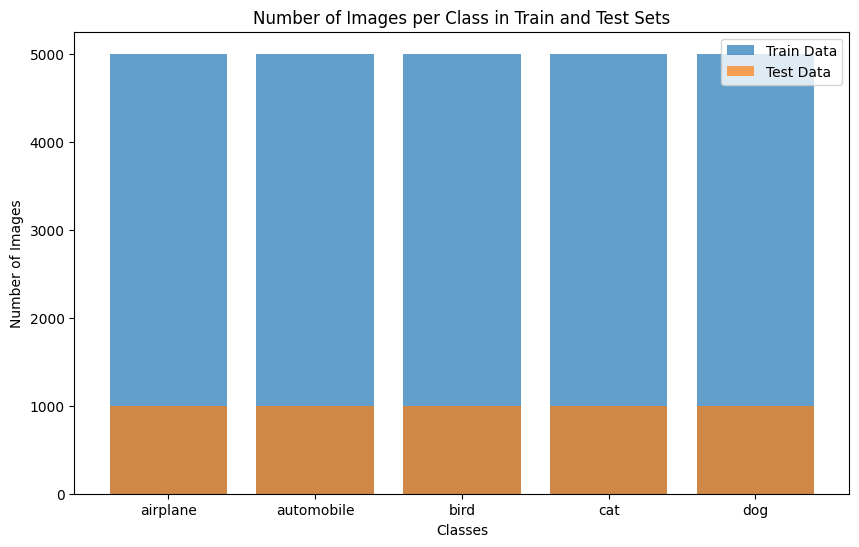

In [ ]:
#Number of images per class
train_counts = {i: np.sum(y_train_mapped == i) for i in range(len(selected_classes))}
test_counts = {i: np.sum(y_test_mapped == i) for i in range(len(selected_classes))}

plt.figure(figsize=(10, 6))
plt.bar(train_counts.keys(), train_counts.values(), alpha=0.7, label='Train Data')
plt.bar(test_counts.keys(), test_counts.values(), alpha=0.7, label='Test Data')
plt.xticks(ticks=range(len(selected_classes)), labels=class_names)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Train and Test Sets')
plt.legend()
plt.show()

##  Visualize sample images

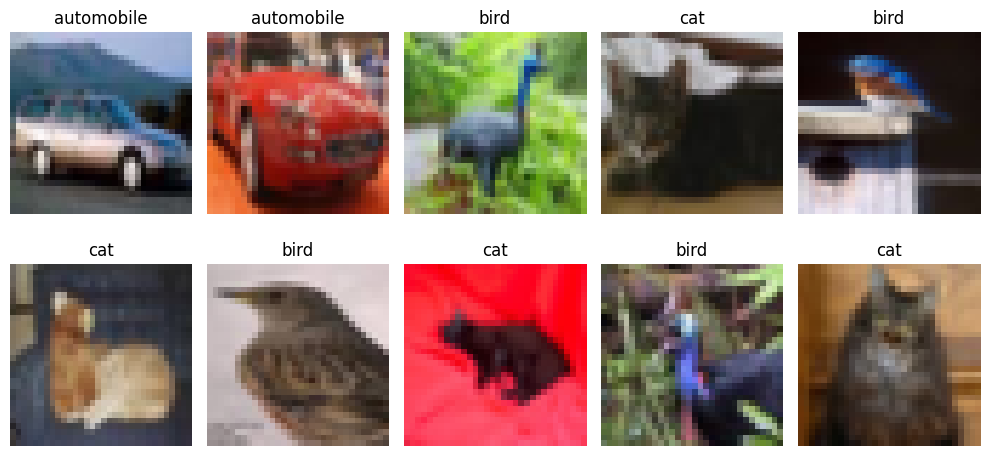

In [ ]:
# Visualize sample images
class_names = ['airplane', 'automobile', 'bird', 'cat', 'dog']
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_subset[i])
    plt.title(class_names[y_train_mapped[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Model Implementation

In [ ]:
# Transfer Learning Model Implementation
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False

## Model Building

In [ ]:
# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(selected_classes), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Data augmentation to prevent overfitting
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,301 (56.64 MB)

 Trainable params: 132,613 (518.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Fit the generator to the training data
datagen.fit(x_train_subset)

# Train the model
history = model.fit(datagen.flow(x_train_subset, y_train_final, batch_size=64),
                    epochs=5,
                    validation_data=(x_test_subset, y_test_final),
                    verbose=1)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 358s 912ms/step - accuracy: 0.5232 - loss: 1.1663 - val_accuracy: 0.6348 - val_loss: 0.9091
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 367s 937ms/step - accuracy: 0.6047 - loss: 0.9898 - val_accuracy: 0.6572 - val_loss: 0.8595
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 353s 862ms/step - accuracy: 0.6168 - loss: 0.9557 - val_accuracy: 0.6630 - val_loss: 0.8501
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 339s 866ms/step - accuracy: 0.6272 - loss: 0.9340 - val_accuracy: 0.6798 - val_loss: 0.8160
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 339s 868ms/step - accuracy: 0.6246 - loss: 0.9242 - val_accuracy: 0.6794 - val_loss: 0.8026


In [ ]:
# Model Evaluation and Optimization
# Evaluate the model
loss, accuracy = model.evaluate(x_test_subset, y_test_final, verbose=2)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

157/157 - 54s - 345ms/step - accuracy: 0.6794 - loss: 0.8026
Test Accuracy: 67.94%


In [ ]:
# Classification report and confusion matrix
y_pred = np.argmax(model.predict(x_test_subset), axis=1)
y_true = np.argmax(y_test_final, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

157/157 ━━━━━━━━━━━━━━━━━━━━ 56s 357ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane       0.77      0.81      0.79      1000
  automobile       0.71      0.85      0.78      1000
        bird       0.68      0.62      0.65      1000
         cat       0.59      0.49      0.53      1000
         dog       0.62      0.62      0.62      1000

    accuracy                           0.68      5000
   macro avg       0.67      0.68      0.67      5000
weighted avg       0.67      0.68      0.67      5000



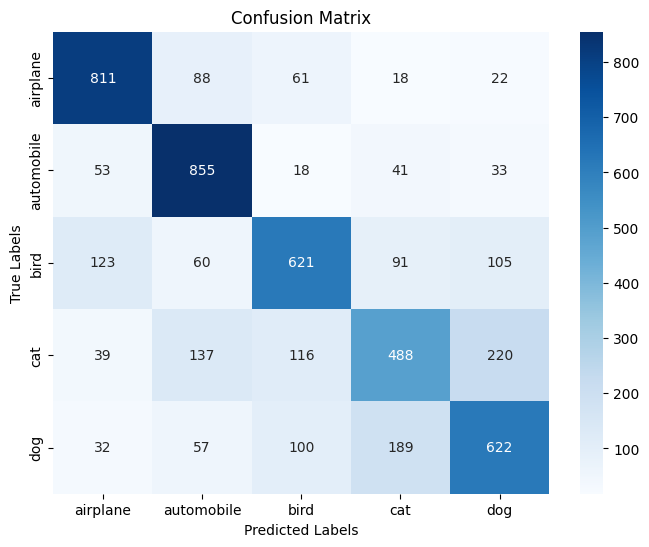

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model
model.save("cifar10_reduced_vgg16.h5")
print("Model saved as cifar10_reduced_vgg16.h5")

Model saved as cifar10_reduced_vgg16.h5


In [ ]:
# Function for Predictions
from tensorflow.keras.models import load_model

def predict_image(image, model_path="cifar10_reduced_vgg16.h5"):
    model = load_model(model_path)
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    class_index = np.argmax(prediction)
    return class_names[class_index]

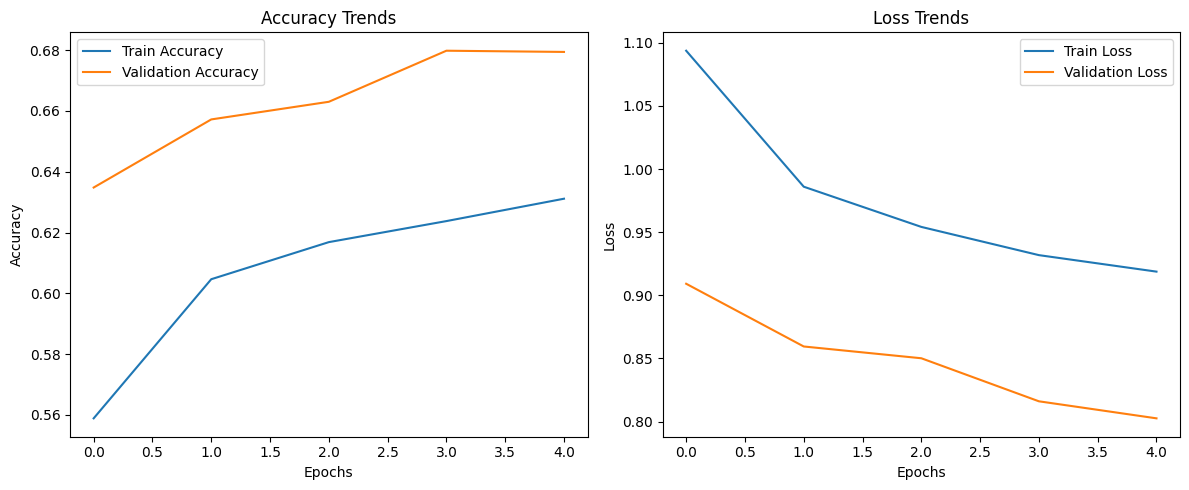

In [ ]:
# Plot Accuracy and Loss Trends
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Trends')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Trends')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()